#环境配置系列

##配置谷歌环境

In [1]:
#认证
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
#挂载云盘
!mkdir -p drive
!google-drive-ocamlfuse drive  -o nonempty

##编程环境

In [4]:
!pip install xgboost
import xgboost as xgb
import pandas as pd
import numpy as np
!pip install lightgbm

    100% |████████████████████████████████| 665kB 1.5MB/s 


##读取数据及初始处理

In [5]:
#读取数据
train_csv = pd.read_csv("drive/Colab_Notebooks/data/round1_ijcai_18_train_20180301.txt"," ")
test_csv = pd.read_csv("drive/Colab_Notebooks/data/round1_ijcai_18_test_a_20180301.txt"," ")
print(len(train_csv),len(test_csv))

478138 18371


In [6]:
train_pd = train_csv.drop_duplicates("instance_id").copy()
test_pd = test_csv.drop_duplicates("instance_id").copy()
print(len(train_csv),len(test_csv))
#补充时间数据
import time
train_pd['day']=train_pd.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x+3600*8)))
train_pd['hour']=train_pd.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x+3600*8)))
test_pd['day']=test_pd.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x+3600*8)))
test_pd['hour']=test_pd.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x+3600*8)))
#展示列名
print("columns length:",len(train_pd.columns))
print("列名：",train_pd.columns)
#时间列
train_time_list = sorted(train_pd["day"].unique())
print("时间序列：",train_time_list)

478138 18371
columns length: 29
列名： Index(['instance_id', 'item_id', 'item_category_list', 'item_property_list',
       'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id',
       'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'predict_category_property',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
       'shop_score_description', 'is_trade', 'day', 'hour'],
      dtype='object')
时间序列： ['2018-09-18', '2018-09-19', '2018-09-20', '2018-09-21', '2018-09-22', '2018-09-23', '2018-09-24']


## Factorization Machine因子分解机尝试

In [0]:
from fastFM import sgd
from sklearn.feature_extraction import DictVectorizer
import numpy as np

v = DictVectorizer()
feature_list = list(train_pd.columns)
feature_list.remove("is_trade")
feature_list.remove("item_category_list")
feature_list.remove("item_property_list")
feature_list.remove("user_id")
feature_list.remove("predict_category_property")



# print(train_pd[feature_list].head().to_dict("records"))
v = DictVectorizer()
X_train = v.fit_transform(train_m[feature_list].copy().to_dict("records"))
X_test = v.transform(test_m[feature_list].copy().to_dict("records"))
y_train = train_m["is_trade"].astype("int").tolist()
y_train_label = np.ones_like(y_train)
y_train_label[y_train<np.mean(y_train)] = -1
y_test = test_m["is_trade"].astype("int").tolist()
y_test_label = np.ones_like(y_test)
y_test_label[y_test<np.mean(y_train)] = -1

fm = sgd.FMClassification()
fm.fit(X_train,y_train_label)
preds = fm.predict_proba(X_test)
from sklearn.metrics import log_loss
print(log_loss(y_test_label,preds))

In [40]:
print(preds)
print(train_m[feature_list].dtypes)

[nan nan nan ... nan nan nan]
context_id                     int64
context_page_id                int64
context_timestamp              int64
day                           object
hour                          object
instance_id                    int64
item_brand_id                  int64
item_city_id                   int64
item_collected_level           int64
item_id                        int64
item_price_level               int64
item_pv_level                  int64
item_sales_level               int64
shop_id                        int64
shop_review_num_level          int64
shop_review_positive_rate    float64
shop_score_delivery          float64
shop_score_description       float64
shop_score_service           float64
shop_star_level                int64
user_gender_id                 int64
user_occupation_id             int64
user_star_level                int64
category                      object
dtype: object


#特征尝试和验证

In [0]:
train_pd = train_csv.drop_duplicates("instance_id").copy()
test_pd = test_csv.drop_duplicates("instance_id").copy()

#补充时间数据
import time
train_pd['day_m']=train_pd.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x+3600*8)))
train_pd['day'] = train_pd.context_timestamp.apply(lambda x:time.strftime("%d",time.localtime(x+3600*8)))
train_pd['hour']=train_pd.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x+3600*8)))
test_pd['day_m']=test_pd.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x+3600*8)))
test_pd['day'] = test_pd.context_timestamp.apply(lambda x:time.strftime("%d",time.localtime(x+3600*8)))
test_pd['hour']=test_pd.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x+3600*8)))

# feature_list = []
feature_list = ['item_id', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
                'item_collected_level', 'item_pv_level', 'user_gender_id', 'user_occupation_id',
                'user_age_level', 'user_star_level', #'user_query_day', 'user_query_day_hour',
                'context_page_id', 'hour', 'shop_id', 'shop_review_num_level', 'shop_star_level',
                'shop_review_positive_rate', 'shop_score_service', 'shop_score_delivery', 'shop_score_description',
                ]
all_data = pd.concat([train_pd,test_pd])
all_data['hour'] = all_data['hour'].astype(int)
all_data['day'] = all_data['hour'].astype(int)
all_data["category"] =  list(map(lambda x:x.split(";")[1],all_data["item_category_list"]))
# feature_one_hot = pd.get_dummies(
#     all_data[["category","item_price_level","user_age_level"]],
#     columns=["category","item_price_level","user_age_level"],
#     prefix=["category","price_level","age_level"]
# )
# #测试后发现item_pv_level贡献很小，且带来太多维度，舍弃
# feature_list += list(feature_one_hot.columns)
# all_data = pd.concat([all_data,feature_one_hot],axis=1)


#重新替换train_pd，test_pd
train_pd = all_data[:len(train_pd)]
test_pd = all_data[len(train_pd):]

#分割线下测试和训练集
train_m = train_pd[(train_pd["day_m"]>='2018-09-18')&(train_pd["day_m"]<='2018-09-23')]
test_m = train_pd[(train_pd["day_m"]>='2018-09-24')]



###双特征

In [0]:
######################双特征算出的trade_ratio，神奇的是这个双特征是的准确度下降###########################
#'''
'''
'''

# def set_gender_brand_ratio(train_df,test_df):
#   ret = train_df[["user_gender_id","item_brand_id","is_trade"]].copy()
#   pv_level_ratio_pd = (ret.groupby(["user_gender_id","item_brand_id"]).sum()["is_trade"])/\
#     (ret.groupby(["user_gender_id","item_brand_id"]).count()["is_trade"])
#   trade_ratio_pd = pv_level_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"gender_brand_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on=["user_gender_id","item_brand_id"],how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on=["user_gender_id","item_brand_id"],how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_gender_brand_ratio(train_m,test_m)
# if "gender_brand_ratio" not in feature_list:
#   feature_list.append("gender_brand_ratio")

  
  
# def set_age_brand_ratio(train_df,test_df):
#   ret = train_df[["user_age_level","item_brand_id","is_trade"]].copy()
#   pv_level_ratio_pd = (ret.groupby(["user_age_level","item_brand_id"]).sum()["is_trade"])/\
#     (ret.groupby(["user_age_level","item_brand_id"]).count()["is_trade"])
#   trade_ratio_pd = pv_level_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"age_brand_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on=["user_age_level","item_brand_id"],how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on=["user_age_level","item_brand_id"],how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_age_brand_ratio(train_m,test_m)
# if "age_brand_ratio" not in feature_list:
#   feature_list.append("age_brand_ratio")
 
  
def set_star_price_ratio(train_df,test_df):
  ret = train_df[["user_star_level","item_price_level","is_trade"]].copy()
  pv_level_ratio_pd = (ret.groupby(["user_star_level","item_price_level"]).sum()["is_trade"])/\
    (ret.groupby(["user_star_level","item_price_level"]).count()["is_trade"])
  trade_ratio_pd = pv_level_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"star_price_ratio"})
  na_value = 0
  train_df = pd.merge(train_df,trade_ratio_pd,on=["user_star_level","item_price_level"],how="left").fillna(na_value)
  test_df = pd.merge(test_df,trade_ratio_pd,on=["user_star_level","item_price_level"],how="left").fillna(na_value)
  return train_df,test_df
train_m,test_m = set_star_price_ratio(train_m,test_m)
if "star_price_ratio" not in feature_list:
  feature_list.append("star_price_ratio")
  


# def set_occupation_brand_ratio(train_df,test_df):
#   ret = train_df[["user_occupation_id","item_brand_id","is_trade"]].copy()
#   pv_level_ratio_pd = (ret.groupby(["user_occupation_id","item_brand_id"]).sum()["is_trade"])/\
#     (ret.groupby(["user_occupation_id","item_brand_id"]).count()["is_trade"])
#   trade_ratio_pd = pv_level_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"occupation_brand_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on=["user_occupation_id","item_brand_id"],how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on=["user_occupation_id","item_brand_id"],how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_occupation_brand_ratio(train_m,test_m)
# if "occupation_brand_ratio" not in feature_list:
#   feature_list.append("occupation_brand_ratio")


# def get_property_dict(df):
#   ret = df[["user_gender_id","item_property_list","is_trade"]].copy()
#   #下面这句骚操作把一行扩展成多行
#   ret = ret.drop('item_property_list', axis=1).join(ret['item_property_list'].str.split(';', expand=True).stack().reset_index(level=1, drop=True).rename('item_property_list'))
#   ret = ret.rename(columns={"item_property_list":"property"})
#   ret = ret.groupby(["property","user_gender_id"]).count()
#   ret = ret.reset_index()
#   print(ret)
#   ret.set_index(["property","user_gender_id"],inplace=True,drop=False)
#   ret["is_trade"] = ret["is_trade"]/ret["is_trade"].max()#归一化
#   return ret
# property_pd = get_property_dict(train_pd)

###单特征

In [0]:
##################单特征或单特征的trade_ratio###########################
'''
'''


# def set_item_trade_ratio(train_df,test_df):
#   ret = train_df[["item_id","is_trade"]].copy()
#   item_trade_ratio_pd = (ret.groupby("item_id").sum()["is_trade"])/\
#     (ret.groupby("item_id").count()["is_trade"])
#   trade_ratio_pd = item_trade_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"item_trade_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on="item_id",how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on="item_id",how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_item_trade_ratio(train_m,test_m)
# if "item_trade_ratio" not in feature_list:
#   feature_list.append("item_trade_ratio")

# def set_brand_trade_ratio(train_df,test_df):
#   ret = train_df[["item_brand_id","is_trade"]].copy()
#   brand_trade_ratio_pd = (ret.groupby("item_brand_id").sum()["is_trade"])/\
#     (ret.groupby("item_brand_id").count()["is_trade"])
#   trade_ratio_pd = brand_trade_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"brand_trade_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on="item_brand_id",how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on="item_brand_id",how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_brand_trade_ratio(train_m,test_m)
# if "brand_trade_ratio" not in feature_list:
#   feature_list.append("brand_trade_ratio")

def set_item_city_ratio(train_df,test_df):
  ret = train_df[["item_city_id","is_trade"]].copy()
  item_city_ratio_pd = (ret.groupby("item_city_id").sum()["is_trade"])/\
    (ret.groupby("item_city_id").count()["is_trade"])
  trade_ratio_pd = item_city_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"item_city_ratio"})
  na_value = 0
  train_df = pd.merge(train_df,trade_ratio_pd,on="item_city_id",how="left").fillna(na_value)
  test_df = pd.merge(test_df,trade_ratio_pd,on="item_city_id",how="left").fillna(na_value)
  return train_df,test_df
train_m,test_m = set_item_city_ratio(train_m,test_m)
if "item_city_ratio" not in feature_list:
  feature_list.append("item_city_ratio")

def set_user_query_feature(data):
  user_query_day = data.groupby(['user_id', 'day']).size().reset_index().rename(columns={0: 'user_query_day'})
  data = pd.merge(data, user_query_day, 'left', on=['user_id', 'day'])
  user_query_day_hour = data.groupby(['user_id', 'day', 'hour']).size().reset_index().rename(
      columns={0: 'user_query_day_hour'})
  data = pd.merge(data, user_query_day_hour, 'left',
                  on=['user_id', 'day', 'hour'])
  return data
train_m = set_user_query_feature(train_m)
test_m = set_user_query_feature(test_m)
if "user_query_day" not in feature_list:
  feature_list.append("user_query_day")
if "user_query_day_hour" not in feature_list:
  feature_list.append("user_query_day_hour")
  
# def scale_to_one(train_df,test_df,column):
#   all_df = pd.concat([train_df,test_df])
#   all_df[column] = (all_df[column]-all_df[column].min()) / (all_df[column].max()-all_df[column].min())
#   train_df = all_df[:len(train_df)]
#   test_df = all_df[len(test_df):]
#   return train_df,test_df
  
# if "shop_review_positive_rate" not in feature_list:
#   feature_list.append("shop_review_positive_rate")

# if "shop_score_service" not in feature_list:
#   feature_list.append("shop_score_service")

# if "shop_score_delivery" not in feature_list:
#   feature_list.append("shop_score_delivery")

# if "shop_score_description" not in feature_list:
#   feature_list.append("shop_score_description")
  


###PCA

In [9]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
# Standardizing the features
x = StandardScaler().fit_transform(train_m[feature_list].copy())
t = StandardScaler().fit_transform(test_m[feature_list].copy())
pca=PCA(n_components=15)  
train_data = pca.fit_transform(x)
test_data = pca.transform(t)

import lightgbm as lgb
from sklearn.metrics import log_loss,roc_auc_score
clf = lgb.LGBMClassifier(num_leaves=63, max_depth=7, n_estimators=80, n_jobs=20)
clf.fit(train_data, train_m[["is_trade"]].copy())
test_m['lgb_predict'] = clf.predict_proba(test_data,)[:, 1]
print(log_loss(test_m["is_trade"], test_m['lgb_predict']))
print(roc_auc_score(test_m["is_trade"], test_m['lgb_predict']))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.08290633076824314
0.6607862858207132


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


###贡献过小，AUC低于55的特征

In [0]:
#################综合后贡献不大，去掉提升的特征#####################

# def set_item_price_ratio(train_df,test_df):
#   ret = train_df[["item_price_level","is_trade"]].copy()
#   item_price_ratio_pd = (ret.groupby("item_price_level").sum()["is_trade"])/\
#     (ret.groupby("item_price_level").count()["is_trade"])
#   trade_ratio_pd = item_price_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"item_price_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on="item_price_level",how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on="item_price_level",how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_item_price_ratio(train_m,test_m)
# if "item_price_ratio" not in feature_list:
#   feature_list.append("item_price_ratio")

# def set_item_sales_ratio(train_df,test_df):
#   ret = train_df[["item_sales_level","is_trade"]].copy()
#   item_sales_ratio_pd = (ret.groupby("item_sales_level").sum()["is_trade"])/\
#     (ret.groupby("item_sales_level").count()["is_trade"])
#   trade_ratio_pd = item_sales_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"item_sales_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on="item_sales_level",how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on="item_sales_level",how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_item_sales_ratio(train_m,test_m)
# if "item_sales_ratio" not in feature_list:
#   feature_list.append("item_sales_ratio")

#####################AUC低于55的特征#########################


# def set_item_collected_ratio(train_df,test_df):
#   ret = train_df[["item_collected_level","is_trade"]].copy()
#   item_collected_ratio_pd = (ret.groupby("item_collected_level").sum()["is_trade"])/\
#     (ret.groupby("item_collected_level").count()["is_trade"])
#   trade_ratio_pd = item_collected_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"item_collected_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on="item_collected_level",how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on="item_collected_level",how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_item_collected_ratio(train_m,test_m)
# if "item_collected_ratio" not in feature_list:
#   feature_list.append("item_collected_ratio")


# def set_shop_star_ratio(train_df,test_df):
#   ret = train_df[["shop_star_level","is_trade"]].copy()
#   shop_star_ratio_pd = (ret.groupby("shop_star_level").sum()["is_trade"])/\
#     (ret.groupby("shop_star_level").count()["is_trade"])
#   trade_ratio_pd = shop_star_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"shop_star_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on="shop_star_level",how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on="shop_star_level",how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_shop_star_ratio(train_m,test_m)
# if "shop_star_ratio" not in feature_list:
#   feature_list.append("shop_star_ratio")

# def set_pv_level_ratio(train_df,test_df):
#   ret = train_df[["item_pv_level","is_trade"]].copy()
#   pv_level_ratio_pd = (ret.groupby("item_pv_level").sum()["is_trade"])/\
#     (ret.groupby("item_pv_level").count()["is_trade"])
#   trade_ratio_pd = pv_level_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"pv_level_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on="item_pv_level",how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on="item_pv_level",how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_pv_level_ratio(train_m,test_m)
# if "pv_level_ratio" not in feature_list:
#   feature_list.append("pv_level_ratio")

##验证

[0]	train-auc:0.593712	train-logloss:0.564787	test-auc:0.588922	test-logloss:0.564106
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[1]	train-auc:0.616778	train-logloss:0.469716	test-auc:0.607957	test-logloss:0.468424
[2]	train-auc:0.6193	train-logloss:0.396786	test-auc:0.609807	test-logloss:0.395016
[3]	train-auc:0.634133	train-logloss:0.339544	test-auc:0.62334	test-logloss:0.337278
[4]	train-auc:0.633871	train-logloss:0.293893	test-auc:0.623534	test-logloss:0.291208
[5]	train-auc:0.644584	train-logloss:0.257052	test-auc:0.638716	test-logloss:0.253999
[6]	train-auc:0.646547	train-logloss:0.227086	test-auc:0.637996	test-logloss:0.223664
[7]	train-auc:0.651673	train-logloss:0.202586	test-auc:0.643636	test-logloss:0.198811
[8]	train-auc:0.658976	train-logloss:0.182468	test-auc:0.650652	test-logloss:0.178408
[9]	train-auc:0.660748	train-logloss:0.165879	test-auc:0.650962	test-logloss:0.1

[45]	train-auc:0.722934	train-logloss:0.08838	test-auc:0.675368	test-logloss:0.082183
[46]	train-auc:0.723661	train-logloss:0.088328	test-auc:0.674817	test-logloss:0.082195
[47]	train-auc:0.724482	train-logloss:0.088266	test-auc:0.674968	test-logloss:0.082178
[48]	train-auc:0.724891	train-logloss:0.088227	test-auc:0.675028	test-logloss:0.082167
[49]	train-auc:0.725713	train-logloss:0.08817	test-auc:0.675678	test-logloss:0.082137
[50]	train-auc:0.726759	train-logloss:0.088101	test-auc:0.676162	test-logloss:0.08209
[51]	train-auc:0.726974	train-logloss:0.088078	test-auc:0.675569	test-logloss:0.082109
[52]	train-auc:0.727587	train-logloss:0.08804	test-auc:0.675294	test-logloss:0.08211
[53]	train-auc:0.727982	train-logloss:0.088012	test-auc:0.675367	test-logloss:0.082108
[54]	train-auc:0.728876	train-logloss:0.08796	test-auc:0.675714	test-logloss:0.082094
[55]	train-auc:0.729759	train-logloss:0.087907	test-auc:0.675749	test-logloss:0.08209
[56]	train-auc:0.730483	train-logloss:0.087853	tes

[92]	train-auc:0.753445	train-logloss:0.086356	test-auc:0.676031	test-logloss:0.082039
[93]	train-auc:0.75412	train-logloss:0.086307	test-auc:0.676539	test-logloss:0.082025
[94]	train-auc:0.754888	train-logloss:0.086264	test-auc:0.677056	test-logloss:0.082004
[95]	train-auc:0.755427	train-logloss:0.086237	test-auc:0.677048	test-logloss:0.081997
[96]	train-auc:0.756297	train-logloss:0.086179	test-auc:0.677212	test-logloss:0.081992
[97]	train-auc:0.756799	train-logloss:0.086152	test-auc:0.677353	test-logloss:0.081983
[98]	train-auc:0.75733	train-logloss:0.08611	test-auc:0.677423	test-logloss:0.081973
[99]	train-auc:0.75767	train-logloss:0.086081	test-auc:0.677355	test-logloss:0.081986
[100]	train-auc:0.758279	train-logloss:0.086043	test-auc:0.677087	test-logloss:0.082001
[101]	train-auc:0.758822	train-logloss:0.086011	test-auc:0.677522	test-logloss:0.081981
[102]	train-auc:0.759333	train-logloss:0.085973	test-auc:0.67747	test-logloss:0.081986
[103]	train-auc:0.760219	train-logloss:0.0859

[139]	train-auc:0.774686	train-logloss:0.084877	test-auc:0.677934	test-logloss:0.082029
[140]	train-auc:0.775264	train-logloss:0.084843	test-auc:0.678088	test-logloss:0.082031
[141]	train-auc:0.775479	train-logloss:0.084824	test-auc:0.678007	test-logloss:0.08203
[142]	train-auc:0.77591	train-logloss:0.084794	test-auc:0.678026	test-logloss:0.082023
[143]	train-auc:0.776005	train-logloss:0.084781	test-auc:0.677997	test-logloss:0.082023
[144]	train-auc:0.776259	train-logloss:0.08475	test-auc:0.677913	test-logloss:0.08203
[145]	train-auc:0.776568	train-logloss:0.084731	test-auc:0.677803	test-logloss:0.082031
[146]	train-auc:0.776921	train-logloss:0.084699	test-auc:0.677798	test-logloss:0.08203
[147]	train-auc:0.777236	train-logloss:0.084679	test-auc:0.677847	test-logloss:0.082036
[148]	train-auc:0.777614	train-logloss:0.084644	test-auc:0.677732	test-logloss:0.082044
[149]	train-auc:0.778043	train-logloss:0.084613	test-auc:0.677668	test-logloss:0.082051
[150]	train-auc:0.778535	train-loglos

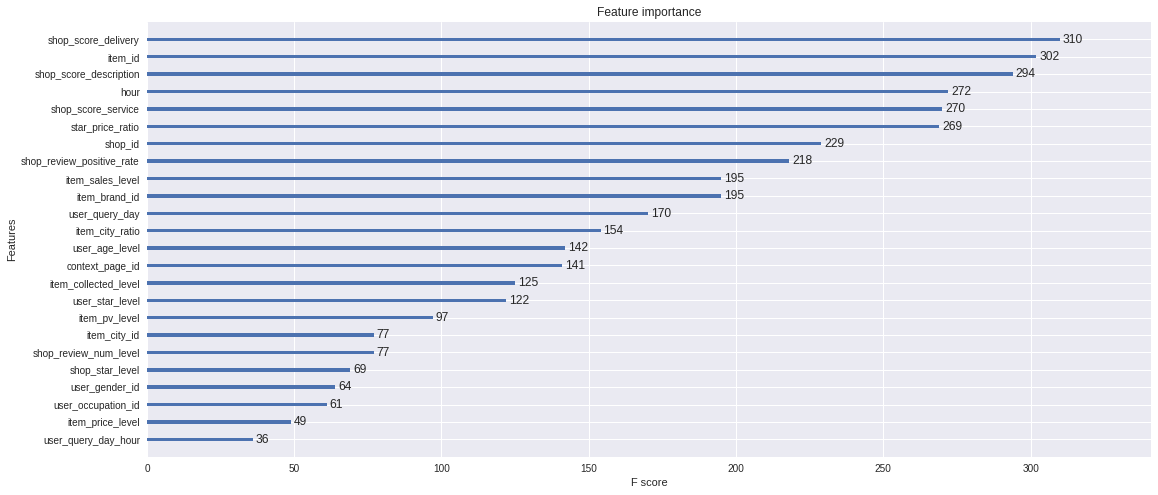

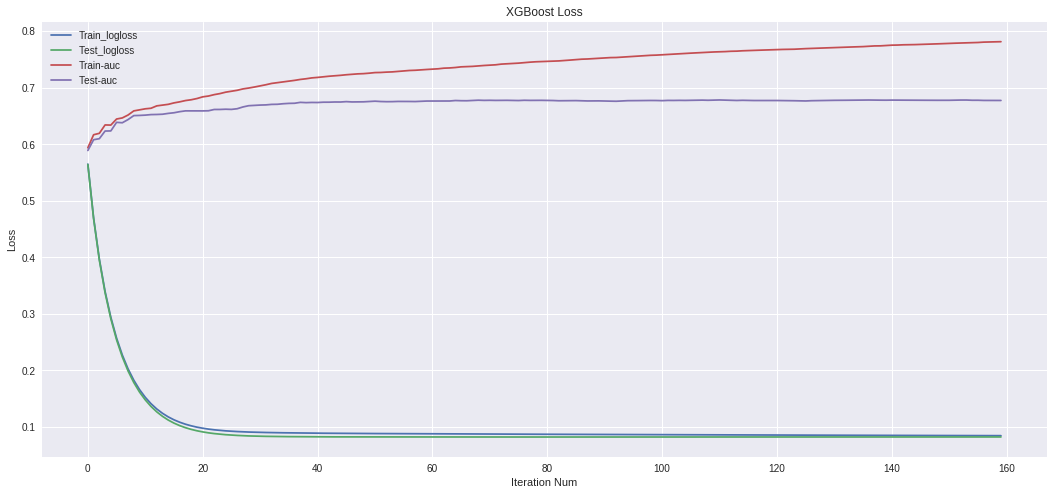

In [24]:
#alpha 30, lambda 15, gamma 2
param = {}
param["eta"] = 0.15
param["min_child_weight"] = 1
param["max_depth"] = 5
param["lambda"] = 5 #控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。 默认1
param["alpha"] = 1 #控制模型复杂程度的权重值的 L1 正则项参数，参数值越大，模型越不容易过拟合。 默认0
param["gamma"] = 1 # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
param["subsample"]=0.8
param["colsample_bytree"]=0.8
param["objective"] = "binary:logistic"
param["eval_metric"]=[ "auc","logloss"]#error,logloss,auc
param["silent"] = 1
num_round = 500
eval_result={}

X = train_m[feature_list].copy()
Y = train_m["is_trade"].copy()
train_set = xgb.DMatrix(X,label=Y)
X_t = test_m[feature_list].copy()
Y_t = test_m["is_trade"].copy()
test_set = xgb.DMatrix(X_t,label=Y_t)
watchlist = [(train_set,'train'), (test_set, 'test')]
model = xgb.train( param, train_set, num_round, watchlist,verbose_eval=True,evals_result=eval_result,early_stopping_rounds=int(0.1*num_round))
limit = model.best_ntree_limit

from matplotlib import pyplot 
from xgboost import plot_importance
#plot feature importance
ax = plot_importance(model,max_num_features=50)
fig = ax.figure
fig.set_size_inches(18, 8)
pyplot.show()

#plot logloss
epochs = len(eval_result['train']['logloss'])  
x_axis = range(0, epochs)  
fig, ax = pyplot.subplots()  
ax.plot(x_axis, eval_result['train']['logloss'], label='Train_logloss')  
ax.plot(x_axis, eval_result['test']['logloss'], label='Test_logloss')  
ax.plot(x_axis, eval_result['train']['auc'], label='Train-auc')  
ax.plot(x_axis, eval_result['test']['auc'], label='Test-auc') 
ax.legend()
fig = ax.figure
fig.set_size_inches(18, 8)
pyplot.ylabel('Loss')  
pyplot.xlabel('Iteration Num')  
pyplot.title('XGBoost Loss')  
pyplot.show()


###lightgbm验证

In [25]:
import lightgbm as lgb
from sklearn.metrics import log_loss,roc_auc_score
clf = lgb.LGBMClassifier(num_leaves=63, max_depth=7, n_estimators=80, n_jobs=20)
clf.fit(train_m[feature_list].copy(), train_m[["is_trade"]].copy(), feature_name=feature_list)
test_m['lgb_predict'] = clf.predict_proba(test_m[feature_list].copy(),)[:, 1]
print(log_loss(test_m["is_trade"], test_m['lgb_predict']))
print(roc_auc_score(test_m["is_trade"], test_m['lgb_predict']))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.08213451580407584
0.6771902316283976


#训练

##xgboost

###参数控制

In [0]:
#alpha 30, lambda 15, gamma 2
param = {}
param["eta"] = 0.15
param["min_child_weight"] = 1
param["max_depth"] = 3
param["lambda"] = 5 #控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。 默认1
param["alpha"] = 4 #控制模型复杂程度的权重值的 L1 正则项参数，参数值越大，模型越不容易过拟合。 默认0
param["gamma"] = 1 # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
param["subsample"]=0.8
param["colsample_bytree"]=0.8
param["objective"] = "binary:logistic"
param["eval_metric"]=[ "auc","logloss"]#error,logloss,auc
param["silent"] = 1
num_round = 500
eval_result={}

###训练模型

In [0]:
X = train_m[feature_list].copy()
Y = train_m["is_trade"].copy()
train_set = xgb.DMatrix(X,label=Y)
X_t = test_m[feature_list].copy()
Y_t = test_m["is_trade"].copy()
test_set = xgb.DMatrix(X_t,label=Y_t)
watchlist = [(train_set,'train'), (test_set, 'test')]
model = xgb.train( param, train_set, num_round, watchlist,verbose_eval=True,evals_result=eval_result,early_stopping_rounds=int(0.1*num_round))
limit = model.best_ntree_limit

###结果展示

In [0]:
from matplotlib import pyplot 
from xgboost import plot_importance
#plot feature importance
ax = plot_importance(model,max_num_features=50)
fig = ax.figure
fig.set_size_inches(18, 8)
pyplot.show()

#plot logloss
epochs = len(eval_result['train']['logloss'])  
x_axis = range(0, epochs)  
fig, ax = pyplot.subplots()  
ax.plot(x_axis, eval_result['train']['logloss'], label='Train_logloss')  
ax.plot(x_axis, eval_result['test']['logloss'], label='Test_logloss')  
ax.plot(x_axis, eval_result['train']['auc'], label='Train-auc')  
ax.plot(x_axis, eval_result['test']['auc'], label='Test-auc') 
ax.legend()
fig = ax.figure
fig.set_size_inches(18, 8)
pyplot.ylabel('Loss')  
pyplot.xlabel('Iteration Num')  
pyplot.title('XGBoost Loss')  
pyplot.show()


###正式训练重新生成特征

In [0]:
# train_pd,test_pd = set_item_trade_ratio(train_pd,test_pd)
# if "item_trade_ratio" not in feature_list:
#   feature_list.append("item_trade_ratio")

# train_pd,test_pd = set_brand_trade_ratio(train_pd,test_pd)
# if "brand_trade_ratio" not in feature_list:
#   feature_list.append("brand_trade_ratio")

train_pd,test_pd = set_item_city_ratio(train_pd,test_pd)
if "item_city_ratio" not in feature_list:
  feature_list.append("item_city_ratio")

# if "shop_review_positive_rate" not in feature_list:
#   feature_list.append("shop_review_positive_rate")

# if "shop_score_service" not in feature_list:
#   feature_list.append("shop_score_service")

# if "shop_score_delivery" not in feature_list:
#   feature_list.append("shop_score_delivery")

# if "shop_score_description" not in feature_list:
#   feature_list.append("shop_score_description")

# train_pd,test_pd = set_gender_brand_ratio(train_pd,test_pd)
# if "gender_brand_ratio" not in feature_list:
#   feature_list.append("gender_brand_ratio")

# train_pd,test_pd = set_age_brand_ratio(train_pd,test_pd)
# if "age_brand_ratio" not in feature_list:
#   feature_list.append("age_brand_ratio")

train_pd,test_pd = set_star_price_ratio(train_pd,test_pd)
if "star_price_ratio" not in feature_list:
  feature_list.append("star_price_ratio")

# train_pd,test_pd = set_occupation_brand_ratio(train_pd,test_pd)
# if "occupation_brand_ratio" not in feature_list:
#   feature_list.append("occupation_brand_ratio")
  
train_pd = set_user_query_feature(train_pd)
test_pd = set_user_query_feature(test_pd)
if "user_query_day" not in feature_list:
  feature_list.append("user_query_day")
if "user_query_day_hour" not in feature_list:
  feature_list.append("user_query_day_hour")

###结果预测

In [27]:
#总训练集生成
X = train_pd[feature_list].copy()
Y = train_pd["is_trade"].copy()
train_set = xgb.DMatrix(X,label=Y)
#测试集生成
X_t = test_pd[feature_list].copy() 
test_set = xgb.DMatrix(X_t)
#训练总模型
watchlist = [(train_set,'train')]
final_model = xgb.train( param, train_set, limit,watchlist)
#预测
predict_out = final_model.predict(test_set,ntree_limit=limit)
test_pd["predicted_score"] = predict_out
result = test_pd[["instance_id","predicted_score"]].copy()

[0]	train-auc:0.592908	train-logloss:0.564631
[1]	train-auc:0.618358	train-logloss:0.469463
[2]	train-auc:0.630992	train-logloss:0.396472
[3]	train-auc:0.649603	train-logloss:0.339149
[4]	train-auc:0.650055	train-logloss:0.293406
[5]	train-auc:0.650482	train-logloss:0.256503
[6]	train-auc:0.65036	train-logloss:0.226504
[7]	train-auc:0.656445	train-logloss:0.201942
[8]	train-auc:0.657955	train-logloss:0.181761
[9]	train-auc:0.658572	train-logloss:0.16516
[10]	train-auc:0.659648	train-logloss:0.151463
[11]	train-auc:0.663004	train-logloss:0.140145
[12]	train-auc:0.665402	train-logloss:0.130807
[13]	train-auc:0.667175	train-logloss:0.123076
[14]	train-auc:0.670058	train-logloss:0.116738
[15]	train-auc:0.670718	train-logloss:0.111501
[16]	train-auc:0.672786	train-logloss:0.107232
[17]	train-auc:0.674148	train-logloss:0.103736
[18]	train-auc:0.676199	train-logloss:0.100857
[19]	train-auc:0.677865	train-logloss:0.098524
[20]	train-auc:0.679182	train-logloss:0.096625
[21]	train-auc:0.681575	t

[65]	train-auc:0.732139	train-logloss:0.086688
[66]	train-auc:0.733136	train-logloss:0.08663
[67]	train-auc:0.733772	train-logloss:0.086585
[68]	train-auc:0.734242	train-logloss:0.086556
[69]	train-auc:0.735578	train-logloss:0.086498
[70]	train-auc:0.736175	train-logloss:0.086467
[71]	train-auc:0.736669	train-logloss:0.086441
[72]	train-auc:0.73765	train-logloss:0.086392
[73]	train-auc:0.738339	train-logloss:0.086355
[74]	train-auc:0.738669	train-logloss:0.086325
[75]	train-auc:0.73908	train-logloss:0.086301
[76]	train-auc:0.73944	train-logloss:0.086274
[77]	train-auc:0.739816	train-logloss:0.086246
[78]	train-auc:0.740285	train-logloss:0.086209
[79]	train-auc:0.740885	train-logloss:0.086178
[80]	train-auc:0.741474	train-logloss:0.086138
[81]	train-auc:0.742237	train-logloss:0.086098
[82]	train-auc:0.742505	train-logloss:0.086071
[83]	train-auc:0.742814	train-logloss:0.086043
[84]	train-auc:0.7435	train-logloss:0.086011
[85]	train-auc:0.743954	train-logloss:0.085973
[86]	train-auc:0.74

###结果保存

In [28]:
#保存文件
time_string = time.strftime('%Y_%m_%d_%H_%M_%S',time.localtime(time.time()+8*3600))
file_name = "drive/Colab_Notebooks/output/"+time_string+ '_'+str(model.best_score).split(".")[1]+".txt"
result.to_csv(file_name,index=False,sep=" ",float_format='%.6f')
print(file_name)

drive/Colab_Notebooks/output/2018_03_20_20_23_04_081943.txt


##浅梦版baseline

In [125]:
import time
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import log_loss,roc_auc_score


def timestamp_datetime(value):
    format = '%Y-%m-%d %H:%M:%S'
    value = time.localtime(value)
    dt = time.strftime(format, value)
    return dt


def convert_data(data):
    data['time'] = data.context_timestamp.apply(timestamp_datetime)
    data['day'] = data.time.apply(lambda x: int(x[8:10]))
    data['hour'] = data.time.apply(lambda x: int(x[11:13]))
    user_query_day = data.groupby(['user_id', 'day']).size(
    ).reset_index().rename(columns={0: 'user_query_day'})
    data = pd.merge(data, user_query_day, 'left', on=['user_id', 'day'])
    user_query_day_hour = data.groupby(['user_id', 'day', 'hour']).size().reset_index().rename(
        columns={0: 'user_query_day_hour'})
    data = pd.merge(data, user_query_day_hour, 'left',
                    on=['user_id', 'day', 'hour'])

    return data


def generate(train_csv,test_csv):
    online = False# 这里用来标记是 线下验证 还是 在线提交

    data = train_csv
    data.drop_duplicates(inplace=True)
    data = convert_data(data)

    if online == False:
        train = data.loc[data.day < 24]  # 18,19,20,21,22,23,24
        test = data.loc[data.day == 24]  # 暂时先使用第24天作为验证集
    elif online == True:
        train = data.copy()
        test = test_csv
        test = convert_data(test)

    features = ['item_id', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
                'item_collected_level', 'item_pv_level', 'user_gender_id', 'user_occupation_id',
                'user_age_level', 'user_star_level', 'user_query_day', 'user_query_day_hour',
                'context_page_id', 'hour', 'shop_id', 'shop_review_num_level', 'shop_star_level',
                'shop_review_positive_rate', 'shop_score_service', 'shop_score_delivery', 'shop_score_description',
                ]
    target = ['is_trade']

    if online == False:
        clf = lgb.LGBMClassifier(num_leaves=63, max_depth=7, n_estimators=80, n_jobs=20)
        clf.fit(train[features], train[target], feature_name=features,
                categorical_feature=['user_gender_id', ])
        test['lgb_predict'] = clf.predict_proba(test[features],)[:, 1]
        print(log_loss(test[target], test['lgb_predict']))
        print(roc_auc_score(test[target], test['lgb_predict']))
    else:
        clf = lgb.LGBMClassifier(num_leaves=63, max_depth=7, n_estimators=80, n_jobs=20)
        clf.fit(train[features], train[target],
                categorical_feature=['user_gender_id', ])
        test['predicted_score'] = clf.predict_proba(test[features])[:, 1]
        time_string = time.strftime('%Y_%m_%d_%H_%M_%S',time.localtime(time.time()+8*3600))
        file_name = "drive/Colab_Notebooks/output/"+time_string+ '_'+str(model.best_score).split(".")[1]+".txt"
        test[['instance_id', 'predicted_score']].to_csv(file_name, index=False,sep=' ')#保存在线提交结果
generate(train_csv,test_csv)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1038: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['user_gender_id']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0.0814328949107014
0.6851492378035364


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
